<a href="https://colab.research.google.com/github/Dhanush7-8/Fake-News-Detection-Using-BERT/blob/main/11_18_group_2_fake_news_detection_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

In [ ]:
fake_data = pd.read_csv("/content/News Dataset/Fake.csv", engine='python')
real_data = pd.read_csv("/content/News Dataset/True.csv", engine='python')

In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


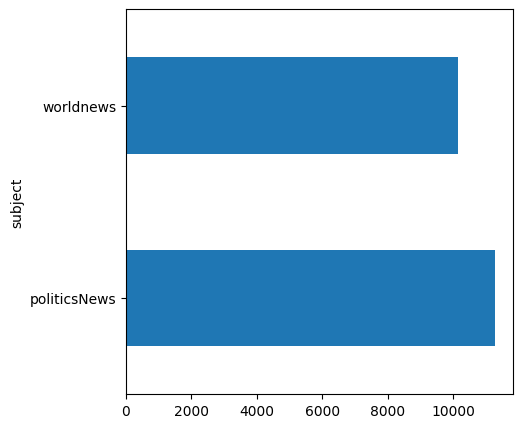

In [ ]:
real_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

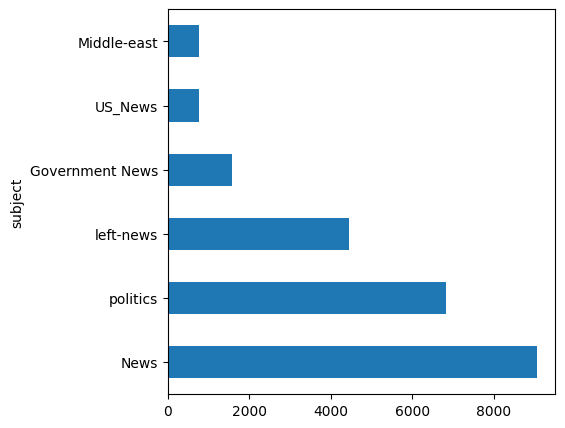

In [ ]:
fake_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

WORLDCLOUD REAL TEXT DATA

In [ ]:
wordcld_mask=np.array(Image.open("/content/News Dataset/twitter.png"))

In [ ]:
wordcld_text=" ".join(real_data["text"].tolist())

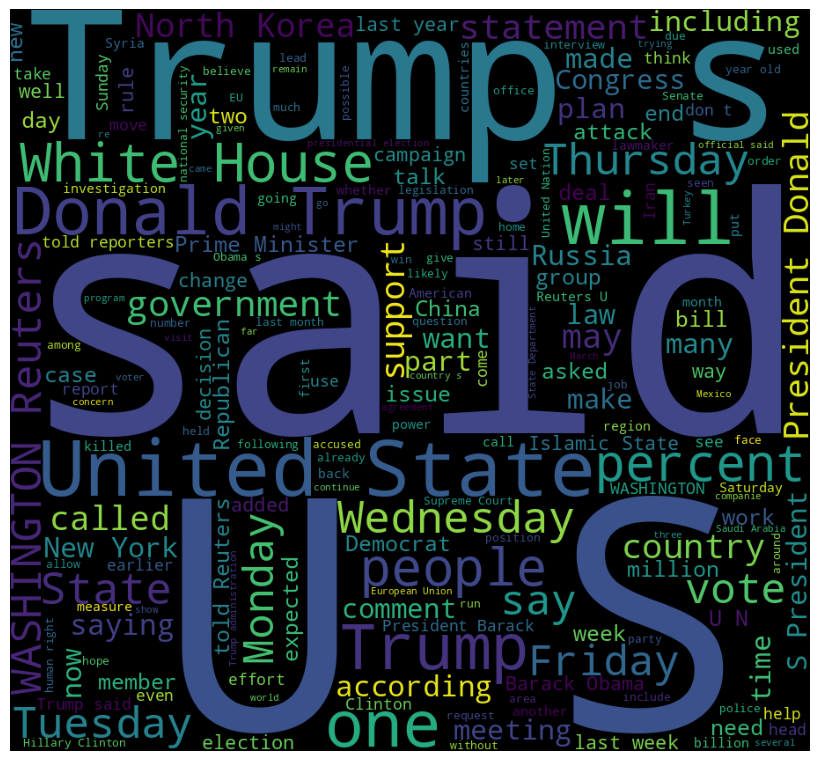

In [ ]:
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

WORLDCLOUD FAKE TEXT DATA

In [ ]:
fake_text=" ".join(fake_data["text"].tolist())

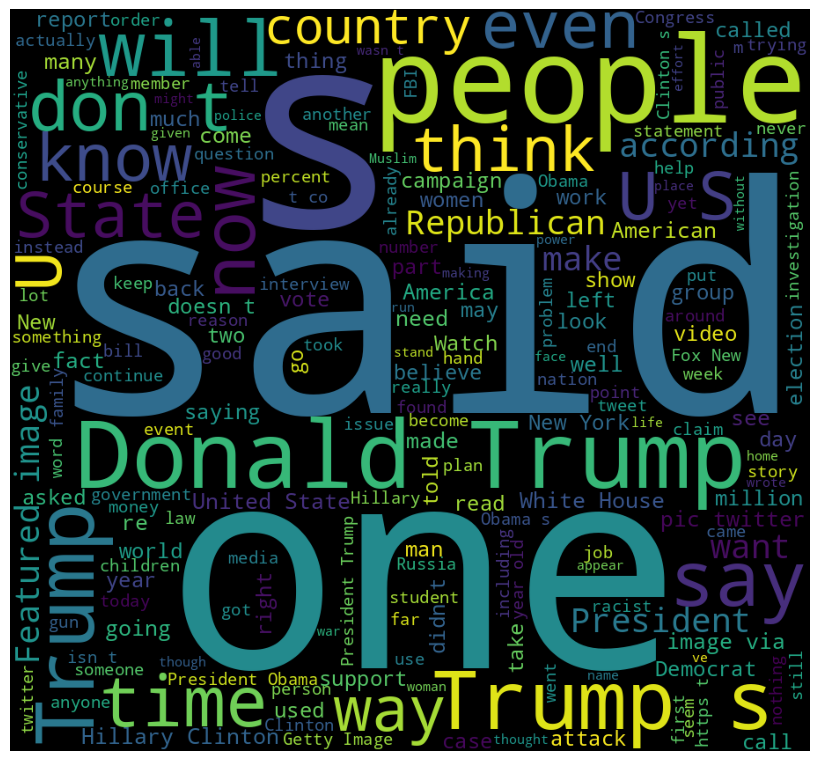

In [ ]:
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(fake_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
fake_data["label"]="fake"
real_data["label"]="real"

In [ ]:
final_data= pd.concat([fake_data,real_data])


In [ ]:
final_data = final_data.sample(frac=1).reset_index(drop=True)

In [ ]:
final_data.head(10)

,title,text,subject,date,label
0,CREEPY: You’ll Never Believe The Deranged Thi...,You know how many Trump fans seem to have a si...,News,"February 19, 2017",fake
1,Trump says U.S. upholds and sticks to 'one Chi...,BEIJING (Reuters) - The United States governme...,worldnews,"November 9, 2017",real
2,BREAKING BAD: John McCain’s Campaign Rocked by...,21st Century Wire asks Will this be the beginn...,US_News,"April 28, 2016",fake
3,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,worldnews,"December 19, 2017",real
4,DISTURBING VIDEO Shows HILLARY’S Campaign Like...,"On September 15, Hillary apparently held a r...",politics,"Sep 19, 2016",fake
5,Trump will get wake-up call when he takes offi...,WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"November 14, 2016",real
6,Nigerian police official defends unit against ...,ABUJA (Reuters) - A police official defended a...,worldnews,"December 6, 2017",real
7,WATCH: Everybody Laughed After Watching This ...,"If you listen to Senator Marco Rubio, ISIS is ...",News,"January 17, 2016",fake
8,THE BEST OF WATTERS’ WORLD: “If liberals are s...,Jesse Watters is pretty awesome! He s great a...,politics,"Mar 15, 2016",fake
9,WATCH: Penn Jillette’s Newest Card Trick PERF...,Penn Jillette doesn t want Donald Trump to run...,News,"August 6, 2016",fake


# SOURCE CREDIBILITY

In [ ]:
import re

# weights given to the credibility of the news source. Higher is more trustworthy, lower is more likelihood of fake
source_trust = {
    'reuters.com': 0.95,
    'apnews.com': 0.95,
    'bbc.com': 0.95,
    'npr.org': 0.90,
    'nytimes.com': 0.85,
    'washingtonpost.com': 0.85,
    'foxnews.com': 0.65,
    'cnn.com': 0.70,
    'dailymail.co.uk': 0.50,
    'infowars.com': 0.10,
    'breitbart.com': 0.15,
    'theonion.com': 0.05,
    'naturalnews.com': 0.10,
}

source_mapping = {
    'reuters': 'reuters.com',
    'associated press': 'apnews.com',
    'ap news': 'apnews.com',
    'bbc': 'bbc.com',
    'cnn': 'cnn.com',
    'fox news': 'foxnews.com',
    'new york times': 'nytimes.com',
    'washington post': 'washingtonpost.com',
    'npr': 'npr.org',
    'bloomberg': 'bloomberg.com',
    'usa today': 'usatoday.com',
    'wall street journal': 'wsj.com',
    'the guardian': 'theguardian.com',
    'al jazeera': 'aljazeera.com',
    'daily mail': 'dailymail.co.uk',
    'dailymail': 'dailymail.co.uk',
    'infowars': 'infowars.com',
    'breitbart': 'breitbart.com',
    'the onion': 'theonion.com',
    'natural news': 'naturalnews.com',
}

# Patterns for matching keywords from news text
patterns = {
    'reuters': r'\(reuters\)|\breuters\b',
    'associated press': r'\(associated press\)|\bassociated press\b',
    'ap news': r'\(ap\)\s*-|\bap\s+news\b',  # Only (AP) - or "AP News"
    'bbc': r'\(bbc\)|\bbbc\b',
    'cnn': r'\(cnn\)|\bcnn\b',
    'fox news': r'\(fox news\)|\bfox news\b',
    'new york times': r'\(new york times\)|\bnew york times\b',
    'washington post': r'\(washington post\)|\bwashington post\b',
    'npr': r'\(npr\)|\bnpr\b',
    'bloomberg': r'\(bloomberg\)|\bbloomberg\b',
    'usa today': r'\(usa today\)|\busa today\b',
    'wall street journal': r'\(wall street journal\)|\bwall street journal\b',
    'the guardian': r'\(the guardian\)|\bthe guardian\b',
    'al jazeera': r'\(al jazeera\)|\bal jazeera\b',
    'daily mail': r'\(daily mail\)|\bdaily mail\b',
    'dailymail': r'\(dailymail\)|\bdailymail\b',
    'infowars': r'\(infowars\)|\binfowars\b',
    'breitbart': r'\(breitbart\)|\bbreitbart\b',
    'the onion': r'\(the onion\)|\bthe onion\b',
    'natural news': r'\(natural news\)|\bnatural news\b',
}

"Find news source from the text"
def source_extraction(text):
    text = str(text)

    domains_found = []

    for source_name, pattern in patterns.items():
        if re.search(pattern, text, re.IGNORECASE):
            domains_found.append(source_mapping[source_name])

    return list(set(domains_found))

"""Set credibility based on source"""
def get_credibility(text, label=None):
    domains = source_extraction(text)

    scores = []
    for domain in domains:
        if domain in source_trust:
            scores.append(source_trust[domain])

    if scores:
        return max(scores), domains
    else:
        # If no sources detected but it's real news, give medium credibility
        if label == 'real':
            return 0.5, domains  # Medium credibility for real news without detected sources
        else:
            return 0.25, domains  # Low credibility for fake/news without detected sources

"Apply extraction to entire dataset"
credibility_scores = []
sources_detected = []

for idx, text in enumerate(final_data['text']):
    label = final_data.iloc[idx]['label']  # Get the label for this row
    score, sources = get_credibility(text, label)
    credibility_scores.append(score)
    sources_detected.append(sources)

final_data['source_credibility'] = credibility_scores
final_data['sources_detected'] = sources_detected

print("\nApplying extraction to entire dataset...")

# Analyze the results
def analyze_results(df):
    # Credibility distribution comparison
    print(f"\nCredibility Distribution (New Method):")
    high_cred = df[df['source_credibility'] >= 0.8]
    med_cred = df[(df['source_credibility'] >= 0.5) & (df['source_credibility'] < 0.8)]
    low_cred = df[df['source_credibility'] < 0.5]

    print(f"  High credibility (≥0.8): {len(high_cred)} articles")
    print(f"  Medium credibility (0.5-0.8): {len(med_cred)} articles")
    print(f"  Low credibility (<0.5): {len(low_cred)} articles")

"""Compare how extraction handles real vs fake news"""
def compare_real_vs_fake(df):
    real_news = df[df['label'] == 'real']  # Adjust based on your actual label values
    fake_news = df[df['label'] == 'fake']

    print("\n" + "=" * 60)
    print("REAL vs FAKE NEWS DETECTION")
    print("=" * 60)

    # Average credibility scores
    print(f"\nAverage credibility scores:")
    print(f"  Real news: {real_news['source_credibility'].mean():.3f}")
    print(f"  Fake news: {fake_news['source_credibility'].mean():.3f}")

    # Detection accuracy
    real_correct = (real_news['source_credibility'] >= 0.5).mean()
    fake_correct = (fake_news['source_credibility'] < 0.5).mean()

    print(f"\nDetection accuracy:")
    print(f"  Real news correctly identified (≥0.5): {real_correct:.1%}")
    print(f"  Fake news correctly identified (<0.5): {fake_correct:.1%}")

# Run all analyses
analyze_results(final_data)
compare_real_vs_fake(final_data)
final_data


Applying extraction to entire dataset...

Credibility Distribution (New Method):
  High credibility (≥0.8): 23987 articles
  Medium credibility (0.5-0.8): 3599 articles
  Low credibility (<0.5): 17312 articles

REAL vs FAKE NEWS DETECTION

Average credibility scores:
  Real news: 0.949
  Fake news: 0.377

Detection accuracy:
  Real news correctly identified (≥0.5): 100.0%
  Fake news correctly identified (<0.5): 73.7%


,title,text,subject,date,label,source_credibility,sources_detected
0,CREEPY: You’ll Never Believe The Deranged Thi...,You know how many Trump fans seem to have a si...,News,"February 19, 2017",fake,0.70,[cnn.com]
1,Trump says U.S. upholds and sticks to 'one Chi...,BEIJING (Reuters) - The United States governme...,worldnews,"November 9, 2017",real,0.95,[reuters.com]
2,BREAKING BAD: John McCain’s Campaign Rocked by...,21st Century Wire asks Will this be the beginn...,US_News,"April 28, 2016",fake,0.25,[]
3,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,worldnews,"December 19, 2017",real,0.95,"[apnews.com, reuters.com]"
4,DISTURBING VIDEO Shows HILLARY’S Campaign Like...,"On September 15, Hillary apparently held a r...",politics,"Sep 19, 2016",fake,0.25,[]
...,...,...,...,...,...,...,...
44893,CLINTON GLOBAL INITIATIVE MEMBER TO Moderate F...,How in the heck does the RNC keep getting the...,politics,"Sep 1, 2016",fake,0.25,[]
44894,Ukraine cyber police chief says Ukraine hit by...,KIEV (Reuters) - The chief of Ukraine s cyber ...,worldnews,"October 24, 2017",real,0.95,[reuters.com]
44895,Romney says he will vote for Cruz in Utah pres...,WASHINGTON (Reuters) - Former Republican presi...,politicsNews,"March 18, 2016",real,0.95,[reuters.com]
44896,Jesus Appears On Kimmel To Read GOP Quotes An...,Republicans often claim Jesus as one of their ...,News,"February 3, 2016",fake,0.25,[]


In [ ]:
final_data.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0
source_credibility,0
sources_detected,0


In [ ]:
final_data.drop(["subject","date"], axis=1)

,title,text,label,source_credibility,sources_detected
0,CREEPY: You’ll Never Believe The Deranged Thi...,You know how many Trump fans seem to have a si...,fake,0.70,[cnn.com]
1,Trump says U.S. upholds and sticks to 'one Chi...,BEIJING (Reuters) - The United States governme...,real,0.95,[reuters.com]
2,BREAKING BAD: John McCain’s Campaign Rocked by...,21st Century Wire asks Will this be the beginn...,fake,0.25,[]
3,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,real,0.95,"[apnews.com, reuters.com]"
4,DISTURBING VIDEO Shows HILLARY’S Campaign Like...,"On September 15, Hillary apparently held a r...",fake,0.25,[]
...,...,...,...,...,...
44893,CLINTON GLOBAL INITIATIVE MEMBER TO Moderate F...,How in the heck does the RNC keep getting the...,fake,0.25,[]
44894,Ukraine cyber police chief says Ukraine hit by...,KIEV (Reuters) - The chief of Ukraine s cyber ...,real,0.95,[reuters.com]
44895,Romney says he will vote for Cruz in Utah pres...,WASHINGTON (Reuters) - Former Republican presi...,real,0.95,[reuters.com]
44896,Jesus Appears On Kimmel To Read GOP Quotes An...,Republicans often claim Jesus as one of their ...,fake,0.25,[]


In [ ]:
final_data.head(20)

,title,text,subject,date,label,source_credibility,sources_detected
0,CREEPY: You’ll Never Believe The Deranged Thi...,You know how many Trump fans seem to have a si...,News,"February 19, 2017",fake,0.70,[cnn.com]
1,Trump says U.S. upholds and sticks to 'one Chi...,BEIJING (Reuters) - The United States governme...,worldnews,"November 9, 2017",real,0.95,[reuters.com]
2,BREAKING BAD: John McCain’s Campaign Rocked by...,21st Century Wire asks Will this be the beginn...,US_News,"April 28, 2016",fake,0.25,[]
3,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,worldnews,"December 19, 2017",real,0.95,"[apnews.com, reuters.com]"
4,DISTURBING VIDEO Shows HILLARY’S Campaign Like...,"On September 15, Hillary apparently held a r...",politics,"Sep 19, 2016",fake,0.25,[]
5,Trump will get wake-up call when he takes offi...,WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"November 14, 2016",real,0.95,"[breitbart.com, foxnews.com, reuters.com]"
6,Nigerian police official defends unit against ...,ABUJA (Reuters) - A police official defended a...,worldnews,"December 6, 2017",real,0.95,[reuters.com]
7,WATCH: Everybody Laughed After Watching This ...,"If you listen to Senator Marco Rubio, ISIS is ...",News,"January 17, 2016",fake,0.25,[]
8,THE BEST OF WATTERS’ WORLD: “If liberals are s...,Jesse Watters is pretty awesome! He s great a...,politics,"Mar 15, 2016",fake,0.25,[]
9,WATCH: Penn Jillette’s Newest Card Trick PERF...,Penn Jillette doesn t want Donald Trump to run...,News,"August 6, 2016",fake,0.25,[bloomberg.com]


In [ ]:
final_data.label.value_counts()

,count
label,
fake,23481
real,21417


<Axes: xlabel='label', ylabel='count'>

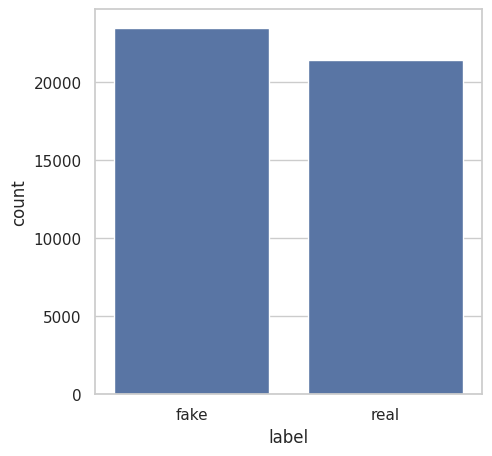

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=final_data["label"])

In [ ]:
final_data.head(5)

,title,text,subject,date,label,source_credibility,sources_detected
0,CREEPY: You’ll Never Believe The Deranged Thi...,You know how many Trump fans seem to have a si...,News,"February 19, 2017",fake,0.70,[cnn.com]
1,Trump says U.S. upholds and sticks to 'one Chi...,BEIJING (Reuters) - The United States governme...,worldnews,"November 9, 2017",real,0.95,[reuters.com]
2,BREAKING BAD: John McCain’s Campaign Rocked by...,21st Century Wire asks Will this be the beginn...,US_News,"April 28, 2016",fake,0.25,[]
3,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,worldnews,"December 19, 2017",real,0.95,"[apnews.com, reuters.com]"
4,DISTURBING VIDEO Shows HILLARY’S Campaign Like...,"On September 15, Hillary apparently held a r...",politics,"Sep 19, 2016",fake,0.25,[]


In [ ]:
final_data["text"]=final_data["title"]+final_data["text"]

In [ ]:
final_data=final_data[["text","label", "source_credibility", "sources_detected"]]

In [ ]:
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})

/tmp/ipython-input-42981109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['label'] = final_data['label'].map({'real':1, 'fake':0})


In [ ]:
final_data.sample(5)

,text,label,source_credibility,sources_detected
32779,Seinfeld’s ‘Elaine’ Wants Bernie Sanders To C...,0,0.25,[]
18220,Trump Is Giddy About His Upcoming Meeting Wit...,0,0.25,[]
24927,Trump travel restrictions hit demand for visit...,1,0.95,[reuters.com]
35828,Interpol approves membership for State of Pale...,1,0.95,[reuters.com]
23334,REVEALED: HOW BARACK OBAMA IS FUNDING The “Res...,0,0.25,[]


In [ ]:
final_data.label[9943]

np.int64(0)

In [ ]:
final_data.text[36709]

'China military sets up website to report leaks, fake newsBEIJING (Reuters) - China s military on Sunday launched a website inviting the public to report leaks and fake news, as well as illegal online activities by military personnel, the latest step in a push to ensure Communist Party control over the internet. Beijing has been ramping up measures to secure the internet and maintain strict censorship, a process that accelerated ahead of the party s five-yearly National Congress that took place in October. The new website is an effort to implement the guiding spirit of the Congress and will help maintain a  clear internet space  surrounding the military, according to 81.cn, the military s official news portal. Citizens are encouraged to use the platform to report online content that attacks the military s absolute leadership and distorts the history of the military and the Communist Party, the website said.  Cases of military personnel illegally opening online social accounts and publi

In [ ]:
max_len=128
data_text=final_data["text"]
data_label=final_data["label"]

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
pip install safetensors


In [ ]:
from transformers import BertModel, AutoTokenizer
# bert_model = TFBertModel.from_pretrained('bert-base-uncased', use_safetensors=False)
bert_model = TFBertModel.from_pretrained('prajjwal1/bert-tiny', from_pt=True)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.embeddings.position_ids', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

In [ ]:
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 128,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [ ]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

**BERT MODEL CREATION**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids = tf.convert_to_tensor(inputs['input_ids'])
        attention_mask = tf.convert_to_tensor(inputs['attention_mask'])
        outputs = self.bert({'input_ids': input_ids, 'attention_mask': attention_mask})
        return outputs.pooler_output

    def compute_output_shape(self, input_shape):
        return (input_shape['input_ids'][0], self.bert.config.hidden_size)

def create_model_with_credibility(bert_model, maxlen=128):
    # Text inputs
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name='attention_mask')

    # Credibility score input
    credibility_input = Input(shape=(1,), dtype=tf.float32, name='credibility_score')

    # BERT embeddings
    bert_layer = BertLayer(bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})

    # Concatenate BERT embeddings with credibility score
    concatenated = Concatenate()([pooled_output, credibility_input])

    # Classification layers
    x = Dropout(0.5)(concatenated)
    x = Dense(64, activation='tanh')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create model with three inputs
    model = Model(
        inputs=[input_ids, attention_mask, credibility_input],
        outputs=output
    )
    return model

# Create the enhanced model
model = create_model_with_credibility(bert_model)

# Prepare your training data with credibility scores
X_train_cred = final_data.loc[X_train.index]['source_credibility'].values
X_test_cred = final_data.loc[X_test.index]['source_credibility'].values

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model with credibility scores
history = model.fit(
    [X_train_token['input_ids'], X_train_token['attention_mask'], X_train_cred],
    Y_train,
    validation_data=(
        [X_test_token['input_ids'], X_test_token['attention_mask'], X_test_cred],
        Y_test
    ),
    epochs=3,
    batch_size=32
)

Epoch 1/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 286s 252ms/step - accuracy: 0.5129 - loss: 0.8351 - val_accuracy: 0.7881 - val_loss: 0.5338
Epoch 2/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 346s 273ms/step - accuracy: 0.6283 - loss: 0.6745 - val_accuracy: 0.8267 - val_loss: 0.4387
Epoch 3/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 279s 248ms/step - accuracy: 0.6981 - loss: 0.5854 - val_accuracy: 0.8433 - val_loss: 0.3858


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric you want to monitor
    patience=3,  # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=3,  # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_lr=1e-6  # Minimum learning rate
)

In [ ]:
# Increase epochs and decrease learning rate to attempt to improve accuracy
model = create_model_with_credibility(bert_model)

# Prepare your training data with credibility scores
X_train_cred = final_data.loc[X_train.index]['source_credibility'].values
X_test_cred = final_data.loc[X_test.index]['source_credibility'].values

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model with credibility scores
history = model.fit(
    [X_train_token['input_ids'], X_train_token['attention_mask'], X_train_cred],
    Y_train,
    validation_data=(
        [X_test_token['input_ids'], X_test_token['attention_mask'], X_test_cred],
        Y_test
    ),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 328s 283ms/step - accuracy: 0.5424 - loss: 0.7803 - val_accuracy: 0.8133 - val_loss: 0.4748
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 281s 250ms/step - accuracy: 0.6770 - loss: 0.6010 - val_accuracy: 0.8478 - val_loss: 0.3838
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 349s 274ms/step - accuracy: 0.7414 - loss: 0.5254 - val_accuracy: 0.8570 - val_loss: 0.3408
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 322s 274ms/step - accuracy: 0.7715 - loss: 0.4800 - val_accuracy: 0.8674 - val_loss: 0.3154
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 326s 278ms/step - accuracy: 0.7898 - loss: 0.4526 - val_accuracy: 0.8722 - val_loss: 0.2988
Epoch 6/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 279s 249ms/step - accuracy: 0.7997 - loss: 0.4345 - val_accuracy: 0.8773 - val_loss: 0.2860
Epoch 7/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 349s 273ms/step - accuracy: 0.8041 - loss: 0.4235 - val_accuracy: 0.8810 - val_loss: 0.2769
Epoch 8/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 302s 255ms/step - ac

# Accuracy History

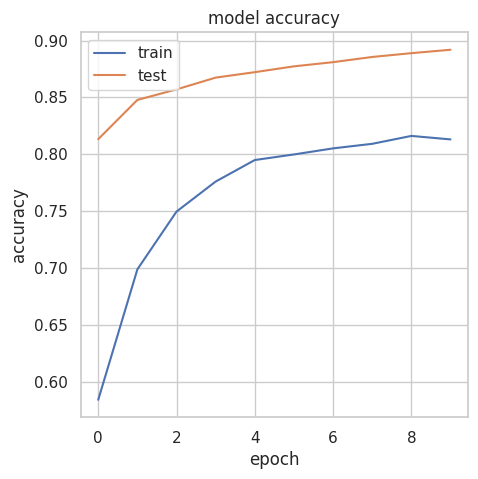

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss History

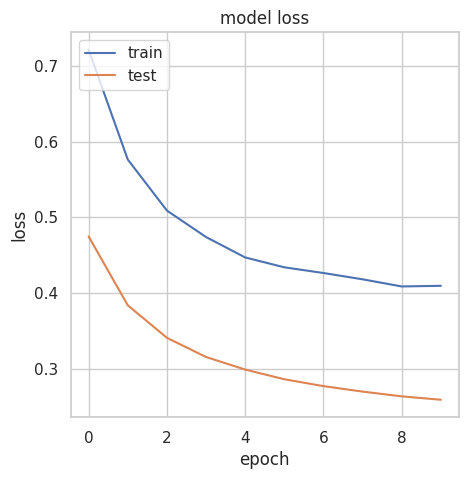

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Making Predictions

In [ ]:
y_pred_proba = model.predict([
    X_test_token['input_ids'],
    X_test_token['attention_mask'],
    X_test_cred  # Include credibility scores
])

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

281/281 ━━━━━━━━━━━━━━━━━━━━ 62s 217ms/step


Confusion Matrix

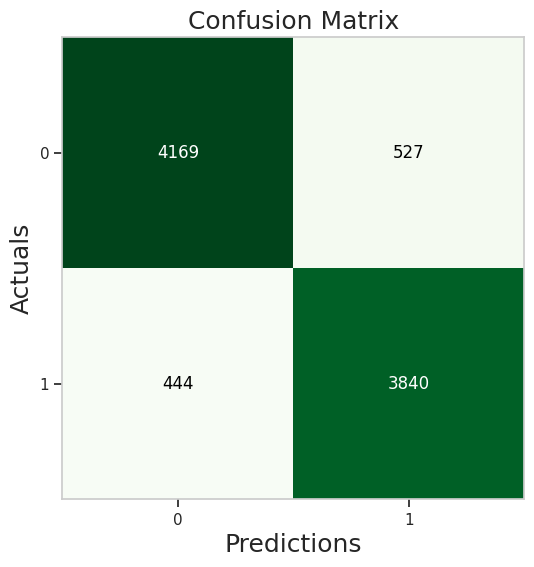

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4696
           1       0.88      0.90      0.89      4284

    accuracy                           0.89      8980
   macro avg       0.89      0.89      0.89      8980
weighted avg       0.89      0.89      0.89      8980



281/281 ━━━━━━━━━━━━━━━━━━━━ 98s 345ms/step


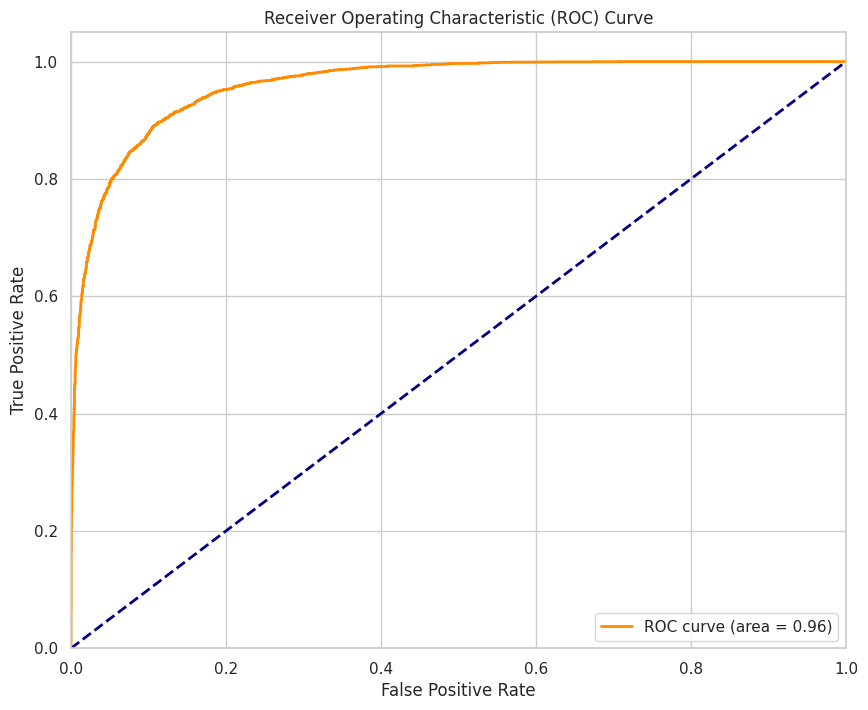

In [ ]:
from sklearn.metrics import roc_curve, auc


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask'],
        'credibility_score': X_test_cred  # Correct key name and syntax
    }
)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)  # Removed indexing on y_pred_prob
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
X_test_cred_reshaped = X_test_cred.reshape(-1, 1)

281/281 ━━━━━━━━━━━━━━━━━━━━ 57s 204ms/step


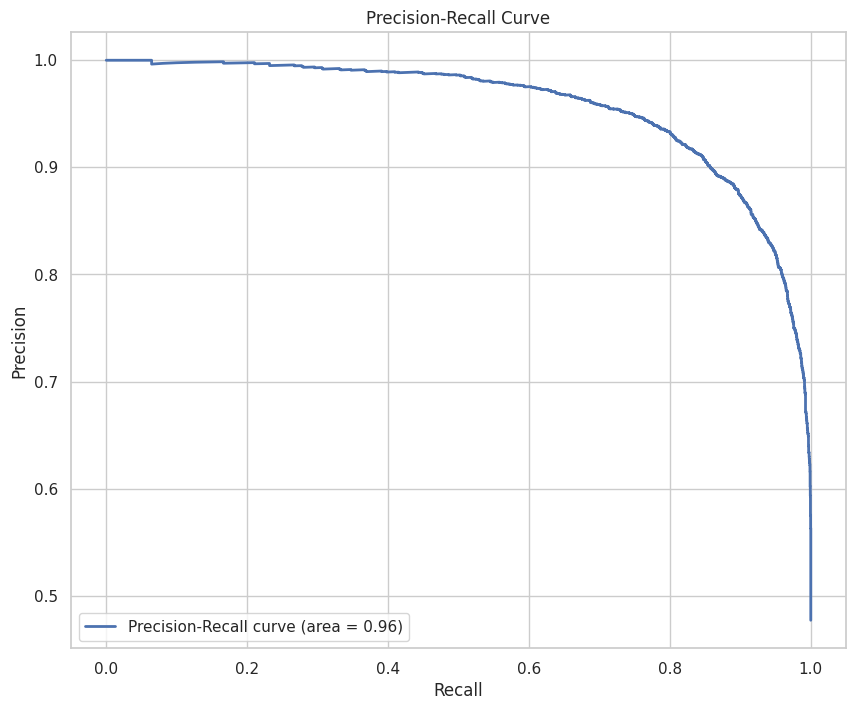

In [ ]:
from sklearn.metrics import precision_recall_curve, auc


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask'],
         'credibility_score': X_test_cred  # Correct key name and syntax
    }
)

precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

281/281 ━━━━━━━━━━━━━━━━━━━━ 60s 214ms/step


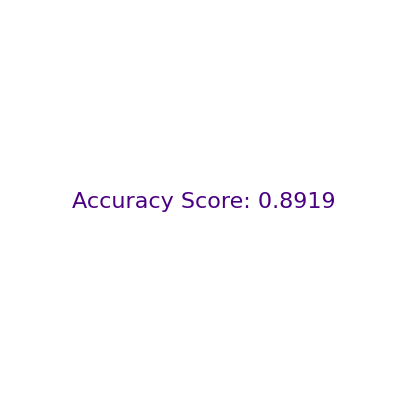

In [ ]:
from sklearn.metrics import accuracy_score


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask'],
        'credibility_score': X_test_cred  # Correct key name and syntax
    }
)
pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(Y_test, pred)

plt.plot([])
plt.text(0, 0, f'Accuracy Score: {accuracy:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

281/281 ━━━━━━━━━━━━━━━━━━━━ 55s 195ms/step


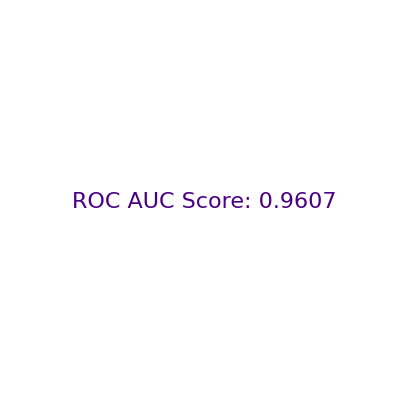

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask'],
        'credibility_score': X_test_cred  # Correct key name and syntax
    }
)
roc_auc = roc_auc_score(Y_test, y_pred_prob)

plt.plot([])
plt.text(0, 0, f'ROC AUC Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

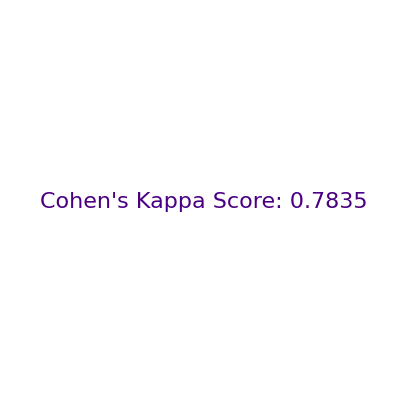

In [ ]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, brier_score_loss
import matplotlib.pyplot as plt

# Assuming you have `y_pred_prob` for predicted probabilities and `Y_test` for true labels
pred = (y_pred_prob > 0.5).astype(int)

cohen_kappa = cohen_kappa_score(Y_test, pred)
matthews_corr = matthews_corrcoef(Y_test, pred)
brier_score = brier_score_loss(Y_test, y_pred_prob)

# Plot Cohen's Kappa Score
plt.plot([])
plt.text(0, 0, f'Cohen\'s Kappa Score: {cohen_kappa:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

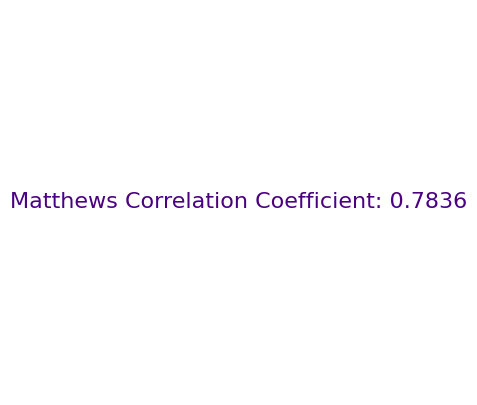

In [ ]:
plt.plot([])
plt.text(0, 0, f'Matthews Correlation Coefficient: {matthews_corr:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

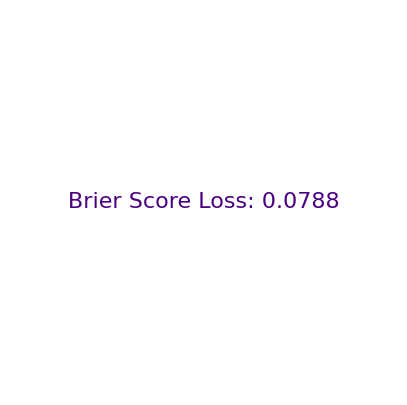

In [ ]:
plt.plot([])
plt.text(0, 0, f'Brier Score Loss: {brier_score:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

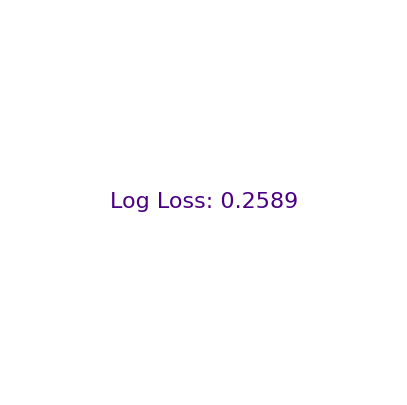

In [ ]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

log_loss_value = log_loss(Y_test, y_pred_prob)

plt.plot([])
plt.text(0, 0, f'Log Loss: {log_loss_value:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

**CUSTOM DATA PREDICTION**

In [ ]:
test_text="Cop Shares Racist Meme About Michelle Obama; Now That Cop Is Having A VERY Bad Day (IMAGES)After the election of Donald Trump many folks seem to see it as a permission slip to be as racist and vile as possible. However, here s the thing, you re still going to get called out as racist and vile. And one Alabama police officer just found this out the hard way.According to the Washington Post: Talladega Police Officer Joel Husk was terminated Wednesday for violating the department s social media and code of conduct policies, City Manager Patrick Bryant said. What did he do? So glad you asked: Husk had posted several memes on his Facebook page, including one showing Obama and Melania Trump.  Fluent in Slovenian, English, French, Serbian, and German,  it said over Trump s photo. Over Obama s, it read:  Fluent in Ghetto. Not only that, he posted several extraordinarily racist memes:via Washington Postvia Washington PostAccording to the City Manager, the statements were  deemed to be biased or racially insensitive or derogatory  and because of that, they  have to take action to correct it. If you re going to be a police officer and serve all the public, you can t assume black people standing up for their rights are equivalent to the KKK. That s about the most horrific equivalence imaginable.Also, according to WaPo: Husk, 37, who had been with the department for about two and a half years, had also shared a meme showing President Obama with the words:  Was Dallas a terrorist attack? Yes! Carried out by Obama s own homegrown terrorist group! Which is a blatant lie and anyone who were to feel that way belongs nowhere near law enforcement. The city took the proper action letting this racist cop go, and hopefully it will be an example to police departments all over the country that this sort of behavior simply cannot be tolerated.Trump s election must not be allowed to serve as a permission slip to bigots everywhere that it s fine to be as awful as possible, because here in the land of the free and the home of the brave, everyone is protected. Everyone, regardless of color, class, gender, sexual orientation, or creed.Featured Photo by Chip Somodevilla/Getty Images'"

In [ ]:
test_token = tokenize(test_text)

In [ ]:
test_text_pred = np.where(model.predict({
    'input_ids' : test_token['input_ids'],
    'attention_mask' : test_token['attention_mask'],
    'credibility_score': X_test_cred  # Correct key name and syntax
}) >= 0.5, 1, 0)

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
test_text_pred

In [ ]:
if(test_text_pred[0]==0):
    print("News is Fake")
else:
    print("News is Real")